## Errors-in-variables estimation of specific climate sensitivity
by D. Heslop (david.heslop@anu.edu.au), E.J. Rohling, G. L. Foster, & J. Yu, submitted.

### Notebook 1 - Create and plot time series
This notebook will create and plot the timeseries shown in Figure 4 based on the global mean surface temperature (GMST) record of Snyder (2016, doi:10.1038/nature19798) and the EPICA Dome C atmospheric CO<sub>2</sub> record of Bereiter et al. (2014, doi:10.1002/2014GL061957).

#### Import packages
Package requirements are provided in the accompanying ```requirements.txt``` file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator
import shutil

#### Test if the user has pdflatex installed for plotting 

In [2]:
if shutil.which('pdflatex') is not None:
    plt.rcParams['text.usetex'] = True

#### Set the random number generator seed to ensure repeatability

In [3]:
seed_value = 54321
np.random.seed(seed_value) #set the random number generator

#### Define the CO$_2$ radiative forcing effect 

A first-order approximation of the radiative forcing effect, $\Delta R_{\mathrm{[CO2]}}$, of CO$_2$ is (Myhre, 1998):

\begin{equation}
f_{\Delta R\mathrm{[CO2]}}(\mathrm{CO}_2) = 5.35 \log(\mathrm{CO}_2 / C_0),
\end{equation}

where $C_0$ is a reference CO$_2$ concentration. Conversion of CO$_2$ into radiative forcing is defined in the ```DeltaF_CO2``` function. 


In [4]:
def DeltaF_CO2(CO2,C0):
    
    ## INPUTS
    # CO2 = CO2 concentration
    # C0 = reference CO2 concentration

    ## OUTPUT
    # radiative forcing in W/m2
    
    return 5.35*np.log((CO2)/C0)

#### Define the age bins for the data (units of ka)

In [5]:
bin_delta = 2 #width of each bin
bin_lim = [0,430] #age interval under consideration
age_bin = np.arange(bin_lim[0]+bin_delta/2,bin_lim[1],bin_delta) #define the bin centres
n_bin = np.size(age_bin) #total number of bins

#### Load the EPICA Dome C atmospheric CO$_2$ record of Bereiter et al. (2014, doi:10.1002/2014GL061957) and find bin averages

In [6]:
CO2 = np.loadtxt('EPICA.txt') #load the data file (columns of age and CO2)
CO2_bin = np.full(n_bin,np.nan) #preallocate array for bin averages
for i in range(n_bin): #loop through bins
    idx = np.logical_and(CO2[:,0]>=age_bin[i]-1,CO2[:,0]<=age_bin[i]+1) #find index of points in given bin
    if np.sum(idx)>0: #if bin contains data points
        CO2_bin[i] = np.mean(CO2[idx,1]) #find average of values within the given bin   

idx = np.where(~np.isnan(CO2_bin)) #find bins that contain values
age_bin, CO2_bin = age_bin[idx], CO2_bin[idx] #select only bins with values
n_bin = np.size(age_bin) #number of bins with values

#### Load the GMST record of Snyder (2016, doi:10.1038/nature19798)


In [7]:
GMST0 = np.loadtxt('GMST.txt') #load the data file (columns of age and GMST)
n_GMST0 = np.shape(GMST0)[0] #number of GMST data points

#### GMST data are defined by quantiles. Use moment-matching to estimate mean and standard deviation corresponding to the uncertainties 

In [8]:
q = np.array([0.025,0.05,0.25,0.5,0.75,0.95,0.975]); #quantiles defining GMST record

def GMST_sse(x,q,X0): 
    
    #objective function to find normal distribution that best matches the provided quantiles
    
    ## INPUTS
    # x = [mean,std] of proposed normal distribution
    # q = quantiles under consideration
    # X0 = GMST values for the quantiles in q
    
    ## OUTPUT
    # sse = sum of squared errors of GMST values and normal distribution predictions for quantiles
    
    sse = np.sum((norm.ppf(q, loc=p0[0], scale=p0[1])-X0[1:])**2)
    
    return sse

#### Employ numerical minimization for find the normal distribution that best fits the GMST quantiles for each age point

In [9]:
GMST = np.zeros((np.shape(GMST0)[0],2)) #preallocate array to store mean and std of normal distributions
for i in range(n_GMST0): #loop through the GMST values
    p0 = np.array([GMST0[i,4],(GMST0[i,-1]-GMST0[i,1])/(2*1.96)]) #initial guess of mean and std based on quantiles
    GMST[i,:] = minimize(GMST_sse, p0, args=(q,GMST0[i,:])).x #minimise sse and output solution

#interpolate GMST fits (means and standard deviations) onto available bin ages
GMST_bin = np.transpose([np.interp(age_bin,GMST0[:,0],GMST[:,0]),np.interp(age_bin,GMST0[:,0],GMST[:,1])])
GMST_bin[:,0] -= GMST_bin[0,0] #subtract mean of first bin from all bins all to create anomalies

#### Create synthetic examples of the CO$_2$ record with 2 ppm and 20 ppm normally distributed uncertainties
Each variable contains the data (1st column) and uncertainty (2nd column). In practice, the uncertainty could be different for each point, but here the uncertainties are assumed to be the same.

In [10]:
CO2_2ppm = np.vstack((CO2_bin+np.random.randn(n_bin)*2,np.ones(n_bin)*2)).T #array with 2 ppm uncertainties
CO2_20ppm = np.vstack((CO2_bin+np.random.randn(n_bin)*20,np.ones(n_bin)*20)).T #array with 20 ppm uncertainties

#### Evaluate the distributions of the radiative forcing effect for the synthetic CO$_2$ record
For plotting this is most easily done numerically via Monte Carlo simulation (takes a little time) 

In [11]:
RCO2_2ppm = np.zeros((n_bin,3)) #preallocate array for 2ppm output
for i in range(n_bin): #loop through the bins
    #generate 1E6 normally distributed values and convert to radiative forcing
    mc = DeltaF_CO2(np.random.randn(int(1E6))*CO2_2ppm[i,1]+CO2_2ppm[i,0],CO2_2ppm[0,0])
    RCO2_2ppm[i,:] = [np.nanpercentile(mc,16),np.mean(mc),np.nanpercentile(mc,84)] #output percentiles (~± 1 sigma)
RCO2_2ppm -= RCO2_2ppm[0,1] #subtract mean of first bin to create anomalies

#repeat the process above for the 20ppm record
RCO2_20ppm = np.zeros((n_bin,3))
for i in range(n_bin):
    mc = DeltaF_CO2(np.random.randn(int(1E6))*CO2_20ppm[i,1]+CO2_20ppm[i,0],CO2_20ppm[0,0])
    RCO2_20ppm[i,:] = [np.nanpercentile(mc,16),np.mean(mc),np.nanpercentile(mc,84)]
RCO2_20ppm -= RCO2_20ppm[0,1]

#### Plot the GMST and radiative forcing time series 

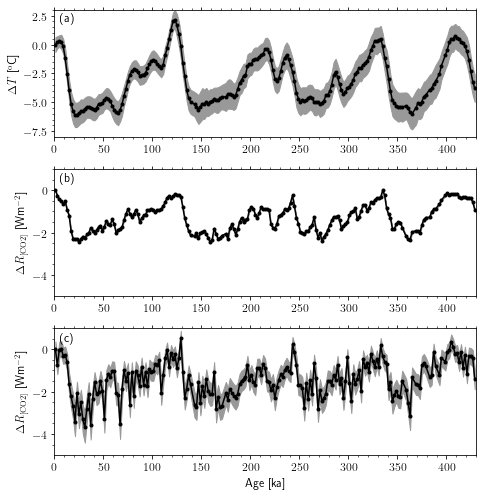

In [12]:
fig, axs = plt.subplots(3,figsize=(6.7,7)) #Define the figure with 3 subplots
color = [0.6,0.6,0.6] #uncertainty shading
fontsize = 12 #plot fontsize

for ax in axs.flat: #set the labelling and ticks for each subplot 
    ax.tick_params(axis='both', labelsize=fontsize, which='both', direction='out', bottom=True, top=True)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

#Plot the GMST record
axs[0].fill_between(age_bin,GMST_bin[:,0]+GMST_bin[:,1],y2=GMST_bin[:,0]-GMST_bin[:,1],color=color) #uncertainty
axs[0].plot(age_bin,GMST_bin[:,0],'.k-') #bin averages
axs[0].set_xlim([0,430]) #set x-axis limits
axs[0].set_ylim([-8,3]) #set y-axis limits

#Plot radiative forcing for the CO2 record with 2ppm uncertainties
axs[1].fill_between(age_bin,RCO2_2ppm[:,2],RCO2_2ppm[:,0],color=color) #uncertainty
axs[1].plot(age_bin,RCO2_2ppm[:,1],'.k-') #bin averages
axs[1].set_xlim([0,430]) #set x-axis limits
axs[1].set_ylim([-5,1]) #set y-axis limits

#Plot radiative forcing for the CO2 record with 20ppm uncertainties
axs[2].fill_between(age_bin,RCO2_20ppm[:,2],RCO2_20ppm[:,0],color=color) #uncertainty
axs[2].plot(age_bin,RCO2_20ppm[:,1],'.k-') #bin averages
axs[2].set_xlim([0,430]) #set x-axis limits
axs[2].set_ylim([-5.0,1]) #set y-axis limits

#label axes
axs[2].set_xlabel('Age [ka]',fontsize=fontsize)
axs[0].set_ylabel(r'$\Delta T$ [$\mathrm{^o}$C]',fontsize=fontsize)
axs[1].set_ylabel(r'$\Delta R_{\mathrm{[CO2]}}$ [Wm$^{-2}$]',fontsize=fontsize)
axs[2].set_ylabel(r'$\Delta R_{\mathrm{[CO2]}}$ [Wm$^{-2}$]',fontsize=fontsize)

#add subplot labels
axs[0].text(5,2,'(a)',fontsize=fontsize)
axs[1].text(5,0.4,'(b)',fontsize=fontsize)
axs[2].text(5,0.4,'(c)',fontsize=fontsize)

plt.tight_layout()
plt.savefig("Figure4.pdf") #save the final figure

#### Save outputs that will be needed in the regression analysis

In [13]:
np.savetxt("age_bin.txt",age_bin) # bin ages
np.savetxt("GMST_bin.txt",GMST_bin) #binned GMST record
np.savetxt("CO2_2ppm.txt",CO2_2ppm) #synthetic CO2 with 2ppm uncertainties
np.savetxt("CO2_20ppm.txt",CO2_20ppm) #synthetic CO2 with 20ppm uncertainties